<a href="https://colab.research.google.com/github/Mansi145/Gender-Classification-/blob/master/Gender_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import cv2
import os
import pandas as pd
import numpy as np
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve, ShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [0]:
path = '/content/gdrive/My Drive/Summer Project/Dataset/Main_Dataset/Train'
os.chdir(path)

In [0]:
face_cascade = cv2.CascadeClassifier('../haarcascade_frontalface_default.xml')
directory_main = os.listdir()
directory_main

['Male', 'Female', 'Gender.csv', 'Gender_array.csv']

In [0]:
for gender in directory_main[:2]:
  print('{} = '.format(gender), len(os.listdir(gender)))

Male =  1939
Female =  1834


In [0]:
gender_features = pd.DataFrame()

In [0]:
for gender in directory_main[:2]:
  
  training_images = os.listdir(gender)
  
  for data in training_images:
    if gender == 'Female':
      label_class = 1
    elif gender == 'Male':
      label_class = 2
        
    path_to_data = gender + '/' + data

    img1 = cv2.imread(path_to_data)
    gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

    face = face_cascade.detectMultiScale(gray,1.3,5)
    for (a,b,w,h) in face:
        face_crop = gray[b:b+h, a:a+w]
        
   
    face_crop_resized = cv2.resize(face_crop, dsize = (80,80))
    
    flattened_face_array = np.append(face_crop_resized, label_class)
    
    series_data_face = pd.Series(flattened_face_array)
    
    gender_features = gender_features.append(series_data_face, ignore_index = True)

gender_features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,6361,6362,6363,6364,6365,6366,6367,6368,6369,6370,6371,6372,6373,6374,6375,6376,6377,6378,6379,6380,6381,6382,6383,6384,6385,6386,6387,6388,6389,6390,6391,6392,6393,6394,6395,6396,6397,6398,6399,6400
0,33.0,36.0,33.0,27.0,21.0,16.0,14.0,13.0,11.0,9.0,9.0,15.0,18.0,21.0,24.0,24.0,23.0,22.0,22.0,27.0,29.0,30.0,30.0,29.0,29.0,30.0,31.0,31.0,29.0,30.0,28.0,24.0,18.0,15.0,16.0,18.0,17.0,17.0,17.0,17.0,...,36.0,36.0,37.0,37.0,38.0,38.0,38.0,38.0,38.0,38.0,39.0,39.0,37.0,36.0,36.0,36.0,36.0,36.0,35.0,34.0,33.0,30.0,28.0,26.0,24.0,22.0,19.0,15.0,12.0,14.0,16.0,15.0,14.0,14.0,14.0,14.0,14.0,15.0,13.0,2.0
1,7.0,8.0,10.0,9.0,8.0,10.0,11.0,11.0,12.0,11.0,13.0,15.0,17.0,23.0,32.0,40.0,39.0,36.0,32.0,29.0,31.0,35.0,37.0,39.0,41.0,42.0,43.0,44.0,43.0,41.0,37.0,33.0,29.0,25.0,22.0,21.0,19.0,16.0,16.0,16.0,...,45.0,45.0,45.0,47.0,47.0,47.0,45.0,43.0,41.0,38.0,37.0,37.0,36.0,35.0,35.0,35.0,39.0,38.0,38.0,37.0,35.0,30.0,26.0,21.0,16.0,11.0,9.0,10.0,11.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,12.0,12.0,12.0,2.0
2,21.0,20.0,18.0,17.0,15.0,13.0,12.0,11.0,10.0,11.0,12.0,18.0,31.0,45.0,53.0,53.0,47.0,40.0,39.0,41.0,47.0,53.0,57.0,58.0,61.0,64.0,67.0,70.0,78.0,82.0,77.0,68.0,57.0,46.0,35.0,29.0,26.0,23.0,19.0,17.0,...,40.0,39.0,38.0,37.0,38.0,40.0,42.0,42.0,40.0,38.0,37.0,37.0,36.0,35.0,34.0,32.0,31.0,30.0,29.0,29.0,29.0,32.0,32.0,30.0,25.0,19.0,14.0,11.0,10.0,11.0,10.0,10.0,10.0,11.0,11.0,11.0,12.0,12.0,12.0,2.0
3,12.0,14.0,18.0,21.0,19.0,14.0,11.0,10.0,11.0,13.0,15.0,17.0,22.0,35.0,53.0,61.0,53.0,40.0,38.0,38.0,38.0,40.0,45.0,52.0,57.0,61.0,59.0,56.0,54.0,51.0,47.0,42.0,39.0,35.0,30.0,25.0,23.0,22.0,20.0,18.0,...,44.0,44.0,43.0,42.0,42.0,43.0,45.0,48.0,50.0,48.0,45.0,43.0,42.0,41.0,39.0,36.0,34.0,32.0,32.0,32.0,35.0,36.0,36.0,37.0,35.0,30.0,24.0,16.0,12.0,12.0,11.0,11.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,2.0
4,12.0,13.0,13.0,13.0,12.0,10.0,12.0,13.0,10.0,7.0,11.0,14.0,20.0,28.0,39.0,48.0,51.0,37.0,33.0,29.0,29.0,34.0,41.0,46.0,50.0,51.0,51.0,50.0,47.0,45.0,43.0,38.0,36.0,32.0,28.0,24.0,21.0,18.0,17.0,17.0,...,45.0,44.0,44.0,43.0,45.0,45.0,44.0,44.0,46.0,48.0,47.0,45.0,43.0,42.0,40.0,38.0,36.0,35.0,34.0,33.0,33.0,34.0,36.0,37.0,36.0,34.0,30.0,23.0,16.0,12.0,13.0,13.0,12.0,9.0,9.0,9.0,10.0,11.0,11.0,2.0


In [0]:
gender_features.rename(columns = {6400: 'Label'}, inplace = True)

In [0]:
gender_features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,6361,6362,6363,6364,6365,6366,6367,6368,6369,6370,6371,6372,6373,6374,6375,6376,6377,6378,6379,6380,6381,6382,6383,6384,6385,6386,6387,6388,6389,6390,6391,6392,6393,6394,6395,6396,6397,6398,6399,Label
0,33.0,36.0,33.0,27.0,21.0,16.0,14.0,13.0,11.0,9.0,9.0,15.0,18.0,21.0,24.0,24.0,23.0,22.0,22.0,27.0,29.0,30.0,30.0,29.0,29.0,30.0,31.0,31.0,29.0,30.0,28.0,24.0,18.0,15.0,16.0,18.0,17.0,17.0,17.0,17.0,...,36.0,36.0,37.0,37.0,38.0,38.0,38.0,38.0,38.0,38.0,39.0,39.0,37.0,36.0,36.0,36.0,36.0,36.0,35.0,34.0,33.0,30.0,28.0,26.0,24.0,22.0,19.0,15.0,12.0,14.0,16.0,15.0,14.0,14.0,14.0,14.0,14.0,15.0,13.0,2.0
1,7.0,8.0,10.0,9.0,8.0,10.0,11.0,11.0,12.0,11.0,13.0,15.0,17.0,23.0,32.0,40.0,39.0,36.0,32.0,29.0,31.0,35.0,37.0,39.0,41.0,42.0,43.0,44.0,43.0,41.0,37.0,33.0,29.0,25.0,22.0,21.0,19.0,16.0,16.0,16.0,...,45.0,45.0,45.0,47.0,47.0,47.0,45.0,43.0,41.0,38.0,37.0,37.0,36.0,35.0,35.0,35.0,39.0,38.0,38.0,37.0,35.0,30.0,26.0,21.0,16.0,11.0,9.0,10.0,11.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,12.0,12.0,12.0,2.0
2,21.0,20.0,18.0,17.0,15.0,13.0,12.0,11.0,10.0,11.0,12.0,18.0,31.0,45.0,53.0,53.0,47.0,40.0,39.0,41.0,47.0,53.0,57.0,58.0,61.0,64.0,67.0,70.0,78.0,82.0,77.0,68.0,57.0,46.0,35.0,29.0,26.0,23.0,19.0,17.0,...,40.0,39.0,38.0,37.0,38.0,40.0,42.0,42.0,40.0,38.0,37.0,37.0,36.0,35.0,34.0,32.0,31.0,30.0,29.0,29.0,29.0,32.0,32.0,30.0,25.0,19.0,14.0,11.0,10.0,11.0,10.0,10.0,10.0,11.0,11.0,11.0,12.0,12.0,12.0,2.0
3,12.0,14.0,18.0,21.0,19.0,14.0,11.0,10.0,11.0,13.0,15.0,17.0,22.0,35.0,53.0,61.0,53.0,40.0,38.0,38.0,38.0,40.0,45.0,52.0,57.0,61.0,59.0,56.0,54.0,51.0,47.0,42.0,39.0,35.0,30.0,25.0,23.0,22.0,20.0,18.0,...,44.0,44.0,43.0,42.0,42.0,43.0,45.0,48.0,50.0,48.0,45.0,43.0,42.0,41.0,39.0,36.0,34.0,32.0,32.0,32.0,35.0,36.0,36.0,37.0,35.0,30.0,24.0,16.0,12.0,12.0,11.0,11.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,2.0
4,12.0,13.0,13.0,13.0,12.0,10.0,12.0,13.0,10.0,7.0,11.0,14.0,20.0,28.0,39.0,48.0,51.0,37.0,33.0,29.0,29.0,34.0,41.0,46.0,50.0,51.0,51.0,50.0,47.0,45.0,43.0,38.0,36.0,32.0,28.0,24.0,21.0,18.0,17.0,17.0,...,45.0,44.0,44.0,43.0,45.0,45.0,44.0,44.0,46.0,48.0,47.0,45.0,43.0,42.0,40.0,38.0,36.0,35.0,34.0,33.0,33.0,34.0,36.0,37.0,36.0,34.0,30.0,23.0,16.0,12.0,13.0,13.0,12.0,9.0,9.0,9.0,10.0,11.0,11.0,2.0


In [0]:
df = gender_features.Label.value_counts()
print('FEMALE FACES = ', df.get_value(1))
print('MALE FACES = ', df.get_value(2))

FEMALE FACES =  1834
MALE FACES =  1939


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
RESIZE_SHAPE = (80,80)
features = gender_features.as_matrix()[:, :RESIZE_SHAPE[0]*RESIZE_SHAPE[1]]
labels = gender_features.as_matrix()[:,RESIZE_SHAPE[0]*RESIZE_SHAPE[1]:]

print("Features Shape = {}".format(features.shape))
print("Labels Shape = {}".format(labels.shape))

Features Shape = (3773, 6400)
Labels Shape = (3773, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
features_counts = [80, 140, 200, 260, 320, 380, 440, 1000]
test_scores = []
train_scores = []
for f_count in features_counts:
    print("Reducing features to {} ...".format(f_count))
    pca = PCA(n_components = f_count)

    pca.fit(features)
    reduced_features = pca.transform(features)
    
    features_train, features_test, labels_train, labels_test = train_test_split(reduced_features, labels, train_size=0.7, test_size=0.3, random_state=42)
    
    logistic_regression = LogisticRegression(C=0.001)
    logistic_regression.fit(features_train, labels_train)
    
    test_score = logistic_regression.score(features_test, labels_test)
    train_score = logistic_regression.score(features_train, labels_train)
    
    print("\t\t\t train_score: {}".format(train_score))
    print("\t\t\t test_score: {}".format(test_score))
    
    test_scores.append(test_score)
    train_scores.append(train_score)

Reducing features to 80 ...


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


			 train_score: 0.9367663763725862
			 test_score: 0.926678445229682
Reducing features to 140 ...


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


			 train_score: 0.9522907989397955
			 test_score: 0.9469964664310954
Reducing features to 200 ...


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


			 train_score: 0.9772813328284741
			 test_score: 0.9540636042402827
Reducing features to 260 ...


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


			 train_score: 0.9981067777357062
			 test_score: 0.950530035335689
Reducing features to 320 ...


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


			 train_score: 1.0
			 test_score: 0.9567137809187279
Reducing features to 380 ...


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


			 train_score: 1.0
			 test_score: 0.9549469964664311
Reducing features to 440 ...


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


			 train_score: 1.0
			 test_score: 0.9628975265017667
Reducing features to 1000 ...


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


			 train_score: 1.0
			 test_score: 0.9690812720848057


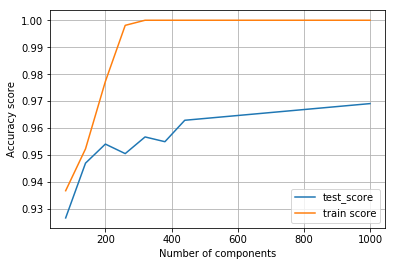

In [0]:
plt.plot(features_counts, test_scores)
plt.plot(features_counts, train_scores)
plt.legend(["test_score", "train score"])
plt.xlabel("Number of components")
plt.ylabel("Accuracy score")
plt.grid()
plt.show()

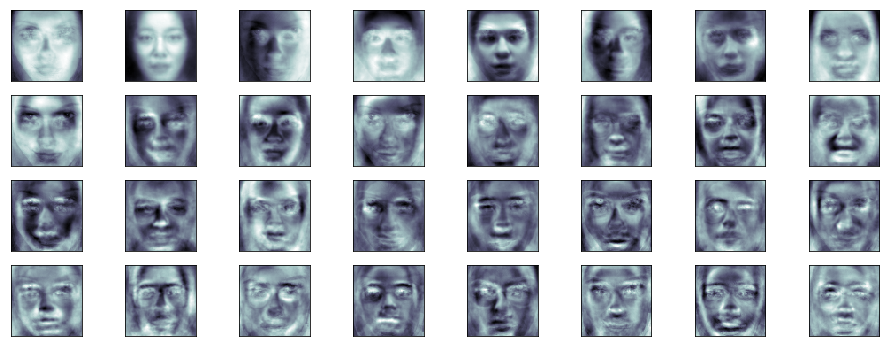

In [0]:
eigenface_scaler = StandardScaler()
eigenface_features = eigenface_scaler.fit_transform(features)

fig = plt.figure(figsize=(16, 6))
pca_eigenface = PCA(n_components = 300, whiten = True)
pca_eigenface.fit(eigenface_features)

for i in range(32):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    plt.imshow(pca_eigenface.components_[i].reshape((80,80)), cmap=plt.cm.bone)

Defining Functions For 

1.   Printing Grid Search Table
2.   Plotting Learning Curve



In [0]:
def print_grid_search_results(grid_search_pipeline, splits):
  
    results = pd.DataFrame(grid_search_pipeline.cv_results_)
    results = results.drop(['mean_fit_time', 'mean_score_time', 'std_fit_time', 'std_score_time', 'params'], axis=1)

    columns = columns={"param_pca__n_components": "PCA", "param_classifier__C": "C", 
                       "mean_test_score": "mean_test","mean_train_score": "mean_train", "rank_test_score": 
                       "rank_test", "param_clf__n_estimators": "n_estimators"}
    
    for i in range(0, splits):
        columns["split" + str(i) + "_train_score"]="split" + str(i) + "_train"
        columns["split" + str(i) + "_test_score"]="split" + str(i) + "_test"
    results = results.rename(columns=columns)
    results.sort_values(by='rank_test', inplace=True)
    return results.head(len(grid_search_pipeline.cv_results_['params']))

In [0]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
 
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1,color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    
    return plt

**LOGISTIC REGRESSION**

In [0]:
logistic_regression = LogisticRegression()
logistic_regression_pipe = Pipeline(steps=[('scaler_before', StandardScaler()), 
                          ('pca', PCA(n_components = 300)),
                          ('scaler_after', StandardScaler()),
                          ('classifier', logistic_regression)])

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, train_size=0.7, test_size=0.3, random_state=42)
logistic_regression_pipe.fit(features_train, labels_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
         steps=[('scaler_before',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=300,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('scaler_after',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [0]:
print("Basic logistic regression test accuracy score: {}".format(logistic_regression_pipe.score(features_test, labels_test)))

print("Basic logistic regression train accuracy score: {}".format(logistic_regression_pipe.score(features_train, labels_train)))

print("Basic logistic regression F1 score: {}".format(f1_score(labels_test, logistic_regression_pipe.predict(features_test))))

Basic logistic regression test accuracy score: 0.9575971731448764
Basic logistic regression train accuracy score: 0.9958349110185536
Basic logistic regression F1 score: 0.9553072625698324


In [0]:
params = dict(classifier__C=[0.0001, 0.001, 0.01, 1],pca__n_components=[250, 300])

kfold = StratifiedKFold(n_splits=5)

grid_search_logistic_regression = GridSearchCV(logistic_regression_pipe, param_grid=params, cv=kfold, return_train_score=True, n_jobs = 6)

grid_search_logistic_regression.fit(features_train, labels_train)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler_before',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=300, random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('scaler_aft...
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                 

In [0]:
print("Logistic Regression Grid Search best parameters: {}".format(grid_search_logistic_regression.best_params_))

Logistic Regression Grid Search best parameters: {'classifier__C': 1, 'pca__n_components': 300}


In [0]:
print("Logistic Regression Grid Search best score: {}".format(grid_search_logistic_regression.best_score_))

Logistic Regression Grid Search best score: 0.9519121544869368


In [0]:
print_grid_search_results(grid_search_logistic_regression, splits=5)

,C,PCA,split0_test,split1_test,split2_test,split3_test,split4_test,mean_test,std_test_score,rank_test,split0_train,split1_train,split2_train,split3_train,split4_train,mean_train,std_train_score
7,1,300,0.948960,0.965974,0.956439,0.950758,0.937381,0.951912,0.009373,1,0.996212,0.997159,0.995267,0.998580,0.997635,0.996971,0.001144
6,1,250,0.937618,0.950851,0.960227,0.941288,0.920304,0.942067,0.013416,2,0.989583,0.986269,0.991481,0.991955,0.991012,0.990060,0.002055
5,0.01,300,0.943289,0.945180,0.943182,0.941288,0.929791,0.940553,0.005512,3,0.967330,0.972064,0.969711,0.975864,0.972564,0.971507,0.002866
4,0.01,250,0.941399,0.948960,0.943182,0.946970,0.920304,0.940174,0.010276,4,0.961648,0.965909,0.959773,0.962612,0.965941,0.963177,0.002423
1,0.0001,300,0.937618,0.945180,0.945076,0.945076,0.920304,0.938660,0.009614,5,0.962121,0.964015,0.965452,0.963559,0.966887,0.964407,0.001634
3,0.001,300,0.935728,0.945180,0.941288,0.946970,0.922201,0.938281,0.008907,6,0.964015,0.964962,0.966398,0.966872,0.964049,0.965259,0.001183
0,0.0001,250,0.939509,0.945180,0.945076,0.937500,0.922201,0.937902,0.008405,7,0.954072,0.961648,0.955987,0.955987,0.959319,0.957402,0.002713
2,0.001,250,0.937618,0.947070,0.941288,0.941288,0.922201,0.937902,0.008404,7,0.954545,0.964015,0.954567,0.955987,0.958373,0.957497,0.003545


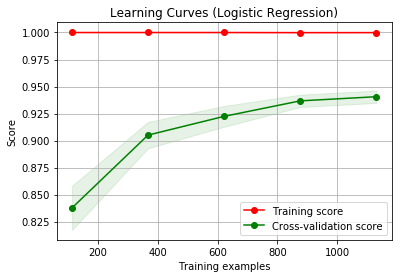

In [0]:
title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits = 10, test_size = 0.7, random_state = 42)
scaled_features = StandardScaler().fit_transform(features)
pca_features = PCA(n_components = 300).fit_transform(scaled_features)
linear_regression_estimator = LogisticRegression(C = 1)

plot_learning_curve(linear_regression_estimator, title, pca_features, labels, ylim=(0.4, 2.), cv=cv, n_jobs=4)
plt.show()

**LINEAR SVM**

In [0]:
linear_svm = LinearSVC()
linear_svm_pipeline = Pipeline(steps=[('scl', StandardScaler()), 
                               ('pca', PCA(n_components=200, random_state=42)),
                               ('scl_2', StandardScaler()),
                               ('clf', linear_svm)])

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, train_size=0.7, test_size=0.3, random_state = 42)


linear_svm_pipeline.fit(features_train, labels_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=200,
                     random_state=42, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('scl_2',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=None,
                           tol=0.0001, verbose=0))],
         verbose=False)

In [0]:
print("SVM Linear test accuracy score: {}".format(linear_svm_pipeline.score(features_test, labels_test)))

print("SVM Linear train accuracy score: {}".format((linear_svm_pipeline.score(features_train, labels_train)) ))

print("SVM Linear F1 score: {}".format(f1_score(labels_test, linear_svm_pipeline.predict(features_test))))

SVM Linear test accuracy score: 0.9540636042402827
SVM Linear train accuracy score: 0.9746308216584627
SVM Linear F1 score: 0.9514925373134329


In [0]:
linear_svm_params = dict(clf__C = [0.0001, 0.001, 1], pca__n_components=[250, 300])

kfold = StratifiedKFold(n_splits=5)

grid_search_linear_svm = GridSearchCV(linear_svm_pipeline, param_grid=linear_svm_params, cv=kfold, return_train_score=True, n_jobs=6)

grid_search_linear_svm.fit(features_train, labels_train)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scl',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=200, random_state=42,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('scl_2',
                                        StandardScaler(...
                                        LinearSVC(C=1.0, class_weight=None,
                                                  dual

In [0]:
print("SVM Linear Grid Search best score: {}".format(grid_search_linear_svm.best_params_))

SVM Gaussian Grid Search best score: {'clf__C': 1, 'pca__n_components': 300}


In [0]:
print("SVM Linear Grid Search best score: {}".format(grid_search_linear_svm.best_score_))

SVM Gaussian Grid Search best score: 0.9454751987883377


In [0]:
print_grid_search_results(grid_search_linear_svm, splits=5)

,param_clf__C,PCA,split0_test,split1_test,split2_test,split3_test,split4_test,mean_test,std_test_score,rank_test,split0_train,split1_train,split2_train,split3_train,split4_train,mean_train,std_train_score
5,1,300,0.945180,0.960302,0.950758,0.948864,0.922201,0.945475,0.012650,1,1.000000,0.999527,0.996214,0.995267,0.998581,0.997918,0.001860
4,1,250,0.947070,0.956522,0.954545,0.937500,0.929791,0.945097,0.010152,2,0.990057,0.998580,0.996687,0.991008,0.999527,0.995172,0.003908
3,0.001,300,0.935728,0.947070,0.943182,0.958333,0.924099,0.941689,0.011423,3,0.965436,0.968750,0.968765,0.970185,0.969253,0.968478,0.001608
2,0.001,250,0.935728,0.947070,0.943182,0.952652,0.916509,0.939038,0.012525,4,0.961174,0.964015,0.958826,0.959773,0.961211,0.961000,0.001755
1,0.0001,300,0.937618,0.943289,0.939394,0.950758,0.920304,0.938281,0.010048,5,0.962121,0.967330,0.964032,0.966872,0.966414,0.965354,0.001976
0,0.0001,250,0.935728,0.945180,0.943182,0.943182,0.920304,0.937524,0.009185,6,0.954072,0.958807,0.956460,0.953147,0.957427,0.955983,0.002097


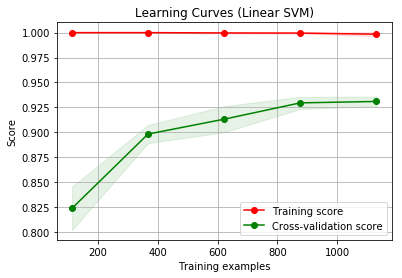

In [0]:
title = "Learning Curves (Linear SVM)"

scaled_features = StandardScaler().fit_transform(features)
pca_features = PCA(n_components = 300).fit_transform(scaled_features)
linear_svm_best_estimator = LinearSVC(C = 1)
cv = ShuffleSplit(n_splits=5, test_size=0.7, random_state=42)

plot_learning_curve(linear_svm_best_estimator, title, pca_features, labels, ylim=(0.4, 2.), cv=cv, n_jobs=4)

plt.show()

**SVM GAUSSIAN**

In [0]:
svm_gaussian = SVC()
svm_pipeline = Pipeline(steps=[('svm_scl_before', StandardScaler()), 
                               ('pca', PCA(n_components=300, random_state=42)),
                               ('svm_scl_after', StandardScaler()),
                               ('svm_gaussian', svm_gaussian)])


features_train, features_test, labels_train, labels_test = train_test_split(features, labels, train_size=0.7, test_size=0.3, random_state=42)
     
svm_pipeline.fit(features_train, labels_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
         steps=[('svm_scl_before',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=300,
                     random_state=42, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('svm_scl_after',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_gaussian',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [0]:
print("SVM Gaussian test accuracy score: {}".format(svm_pipeline.score(features_test, labels_test)))

print("SVM Gaussian train accuracy score: {}".format((svm_pipeline.score(features_train, labels_train)) ))

print("SVM Gaussian F1 score: {}".format(f1_score(labels_test, svm_pipeline.predict(features_test))))

SVM Gaussian test accuracy score: 0.9743816254416962
SVM Gaussian train accuracy score: 0.9981067777357062
SVM Gaussian F1 score: 0.9726672950047125


In [0]:
svm_params = dict(svm_gaussian__C = [0.75, 1], svm_gaussian__gamma = [0.007, 0.0075])

kfold = StratifiedKFold(n_splits=5)

grid_search_svm = GridSearchCV(svm_pipeline, param_grid=svm_params, cv = kfold, return_train_score=True, n_jobs=6)

grid_search_svm.fit(features_train, labels_train)


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('svm_scl_before',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=300, random_state=42,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('svm_scl_aft...
                                            decision_function_shape='ovr',
                                            degree=3, gamma='auto_deprecated',
                 

In [0]:
grid_search_svm.best_params_

{'svm_gaussian__C': 1, 'svm_gaussian__gamma': 0.007}

In [0]:
print("SVM Gaussian Grid Search best score: {}".format(grid_search_svm.best_score_))

SVM Gaussian Grid Search best score: 0.9700870882241576


In [0]:
print_grid_search_results(grid_search_svm, splits=5)

,param_svm_gaussian__C,param_svm_gaussian__gamma,split0_test,split1_test,split2_test,split3_test,split4_test,mean_test,std_test_score,rank_test,split0_train,split1_train,split2_train,split3_train,split4_train,mean_train,std_train_score
2,1,0.007,0.975425,0.967864,0.979167,0.975379,0.952562,0.970087,0.009490,1,1.0,1.000000,1.000000,1.0,1.0,1.000000,0.000000
3,1,0.0075,0.967864,0.967864,0.982955,0.973485,0.950664,0.968573,0.010506,2,1.0,1.000000,1.000000,1.0,1.0,1.000000,0.000000
0,0.75,0.007,0.930057,0.969754,0.956439,0.975379,0.941176,0.954563,0.017018,3,1.0,0.999527,0.999527,1.0,1.0,0.999811,0.000232
1,0.75,0.0075,0.916824,0.964083,0.948864,0.962121,0.924099,0.943203,0.019429,4,1.0,1.000000,0.999527,1.0,1.0,0.999905,0.000189


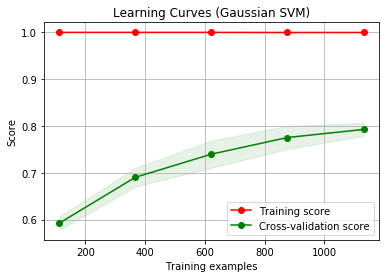

In [0]:
title = "Learning Curves (Gaussian SVM)"

scaled_features = StandardScaler().fit_transform(features)
pca_features = PCA(n_components = 300).fit_transform(scaled_features)
svm_best_estimator = SVC(C = 1, gamma = 0.007)
cv = ShuffleSplit(n_splits=5, test_size=0.7, random_state=42)

plot_learning_curve(svm_best_estimator, title, pca_features, labels, ylim=(0.4, 2.), cv=cv, n_jobs=4)

plt.show()

**Basic Random Forest**

In [0]:
forest_pipeline = Pipeline(steps=[('scaler', StandardScaler()), 
                                  ('pca', PCA(n_components = 300)),
                                  ('scaler_1', StandardScaler()),
                                  ('clf', RandomForestClassifier(criterion='gini'))])

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, train_size=0.7, test_size=0.3, random_state = 42)

forest_pipeline.fit(features_train, labels_train)

print("Test score: {}".format(forest_pipeline.score(features_test, labels_test))) 
print("Train score: {}".format(forest_pipeline.score(features_train, labels_train))) 

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Test score: 0.9337455830388692
Train score: 0.9965921999242711


In [0]:
print("Basic Random Forest test accuracy score: {}".format(forest_pipeline.score(features_test, labels_test)))

print("Basic Random Forest train accuracy score: {}".format((forest_pipeline.score(features_train, labels_train)) ))

print("Basic Random Forest F1 score: {}".format(f1_score(labels_test, forest_pipeline.predict(features_test))))

Basic Random Forest test accuracy score: 0.9337455830388692
Basic Random Forest train accuracy score: 0.9965921999242711
Basic Random Forest F1 score: 0.9299719887955182


In [0]:
forest_params = dict(clf__n_estimators = [1500, 2000], clf__max_depth=[2, 3])

kfold = StratifiedKFold(n_splits=5)

grid_search_forest = GridSearchCV(forest_pipeline, param_grid=forest_params, cv=kfold, return_train_score=True, n_jobs=6)

grid_search_forest.fit(features_train, labels_train)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=300, random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('scaler_1',
                                        Standar...
                                                               min_impurity_split=None,
                                          

In [0]:
print("Basic Random Forest Grid Search best parameters: {}".format(grid_search_forest.best_params_))

Basic Random Forest Grid Search best parameters: {'clf__max_depth': 3, 'clf__n_estimators': 2000}


In [0]:
print("Basic Random Forest Grid Search best score: {}".format(grid_search_forest.best_score_))

Basic Random Forest Grid Search best score: 0.9140477092010602


In [0]:
print_grid_search_results(grid_search_forest, splits=5)

,param_clf__max_depth,n_estimators,split0_test,split1_test,split2_test,split3_test,split4_test,mean_test,std_test_score,rank_test,split0_train,split1_train,split2_train,split3_train,split4_train,mean_train,std_train_score
3,3,2000,0.899811,0.924386,0.920455,0.920455,0.905123,0.914048,0.009711,1,0.936080,0.937027,0.936583,0.934217,0.934721,0.935725,0.001081
2,3,1500,0.901701,0.926276,0.905303,0.918561,0.905123,0.911397,0.009419,2,0.939867,0.936080,0.934690,0.934217,0.938978,0.936766,0.002271
0,2,1500,0.877127,0.896030,0.897727,0.909091,0.882353,0.892465,0.011440,3,0.906723,0.911932,0.906768,0.919072,0.910596,0.911018,0.004525
1,2,2000,0.869565,0.907372,0.897727,0.901515,0.884250,0.892086,0.013594,4,0.913352,0.915720,0.915286,0.911500,0.908704,0.912912,0.002585


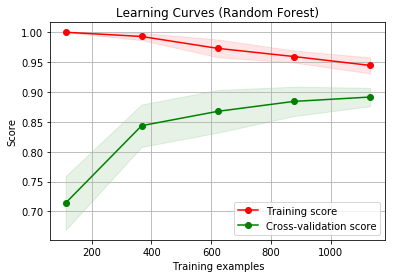

In [0]:
Title = "Learning Curves (Random Forest)"

scaled_features = StandardScaler().fit_transform(features)
pca_features = PCA(n_components = 300).fit_transform(scaled_features)
forest_estimator = RandomForestClassifier(max_depth = 3, n_estimators = 2000)
cv = ShuffleSplit(n_splits=5, test_size=0.7, random_state=42)

plot_learning_curve(forest_estimator, Title, pca_features, labels, ylim=(0.4, 2.), cv=cv, n_jobs=6)

plt.show()

**BASIC ADABOOST WITH DECISION TREE**

In [0]:
tree = DecisionTreeClassifier(max_depth=1)

ada_boost_pipeline = Pipeline(steps=[('scaler', StandardScaler()), 
                                  ('pca', PCA(n_components = 300)),
                                  ('scaler_1', StandardScaler()),
                                  ('clf', AdaBoostClassifier(tree))])

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, train_size=0.7, test_size=0.3, random_state = 42)

ada_boost_pipeline.fit(features_train, labels_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=300,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('scaler_1',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 AdaBoostClassifier(algorithm='SAMME.R',
                                    base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                          criterion='gini',
                                                                          max_depth=1,
                                                                          max_features=None,
                                                                          max_leaf_nodes=None,
                           

In [0]:
print("ADABOOST Tree test accuracy score: {}".format(forest_pipeline.score(features_test, labels_test)))

print("ADABOOST Tree train accuracy score: {}".format((forest_pipeline.score(features_train, labels_train)) ))

print("ADABOOST Tree F1 score: {}".format(f1_score(labels_test, forest_pipeline.predict(features_test))))

ADABOOST Tree test accuracy score: 0.9337455830388692
ADABOOST Tree train accuracy score: 0.9965921999242711
ADABOOST Tree F1 score: 0.9299719887955182


In [0]:
params = dict(clf__n_estimators=[100, 150], clf__learning_rate=[0.1, 0.35, 0.5])

kfold = StratifiedKFold(n_splits=5)

ada_boost_grid_search = GridSearchCV(ada_boost_pipeline, param_grid=params, cv=kfold, return_train_score=True, n_jobs=6)

ada_boost_grid_search.fit(features_train, labels_train)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=300, random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('scaler_1',
                                        Standar...
                                                                                                 min_samples_leaf=1,
             

In [0]:
print("Basic Adaboost Random Forest Grid Search best parameters : {}".format(ada_boost_grid_search.best_params_))

Basic Adaboost Random Forest Grid Search best parameters : {'clf__learning_rate': 0.5, 'clf__n_estimators': 150}


In [0]:
print("Basic Adaboost Random Forest Grid Search best score : {}".format(ada_boost_grid_search.best_score_))

Basic Adaboost Random Forest Grid Search best score : 0.9420673987126088


In [0]:
print_grid_search_results(ada_boost_grid_search, splits=5)

,param_clf__learning_rate,n_estimators,split0_test,split1_test,split2_test,split3_test,split4_test,mean_test,std_test_score,rank_test,split0_train,split1_train,split2_train,split3_train,split4_train,mean_train,std_train_score
5,0.5,150,0.930057,0.941399,0.945076,0.946970,0.920304,0.936766,0.010100,1,0.985322,0.990530,0.987222,0.987222,0.988647,0.987789,0.001731
3,0.35,150,0.920605,0.941399,0.954545,0.929924,0.920304,0.933359,0.013101,2,0.974905,0.979640,0.975390,0.968765,0.970199,0.973780,0.003903
4,0.5,100,0.931947,0.939509,0.922348,0.928030,0.924099,0.929193,0.006136,3,0.969697,0.973011,0.970658,0.967818,0.968307,0.969898,0.001853
2,0.35,100,0.916824,0.926276,0.931818,0.922348,0.918406,0.923135,0.005442,4,0.957386,0.956913,0.956933,0.952201,0.954588,0.955604,0.001963
1,0.1,150,0.888469,0.890359,0.890152,0.886364,0.903226,0.891708,0.005927,5,0.922822,0.911932,0.913393,0.910554,0.915326,0.914805,0.004310
0,0.1,100,0.862004,0.873346,0.857955,0.865530,0.870968,0.865960,0.005649,6,0.890625,0.899148,0.888310,0.882158,0.886471,0.889342,0.005634


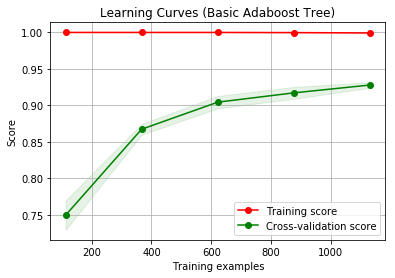

In [0]:
Title = "Learning Curves (Basic Adaboost Tree)"

scaled_features = StandardScaler().fit_transform(features)
pca_features = PCA(n_components = 300).fit_transform(scaled_features)
ada_tree_estimator = AdaBoostClassifier(tree, learning_rate = 0.5, n_estimators = 150)
cv = ShuffleSplit(n_splits=5, test_size=0.7, random_state=42)

plot_learning_curve(ada_tree_estimator, Title, pca_features, labels, ylim=(0.4, 2.), cv=cv, n_jobs=6)

plt.show()

COMPARING THE CLASSIFIERS

In [0]:
the_scores = {'Classifier' : ['Logistic Regression', 
                                         'Linear SVM', 
                                         'Gaussian SVM', 
                                         'Random Forest', 
                                         'AdaBoost with Decision tree'] ,
                         'Best Score' : [grid_search_logistic_regression.best_score_, 
                                         grid_search_linear_svm.best_score_, 
                                         grid_search_svm.best_score_,
                                         grid_search_forest.best_score_,
                                         ada_boost_grid_search.best_score_]}

the_algos = pd.DataFrame(data = the_scores)

the_algos

,Classifier,Best Score
0,Logistic Regression,0.951912
1,Linear SVM,0.945475
2,Gaussian SVM,0.970087
3,Random Forest,0.914048
4,AdaBoost with Decision tree,0.936766
